In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
import sys
import pickle
import joblib
import os
import gc

from itertools import product

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization

from tensorflow.keras.regularizers import l1, l2

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

tf.test.gpu_device_name()
tf.device('/GPU:0')

import optuna
from optuna.samplers import TPESampler

from sklearn.manifold import TSNE

2024-12-08 15:30:41.759681: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-08 15:30:45.725453: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 15:30:45.751611: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-08 15:30:46.341752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 15:30:46.341811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name:

In [2]:

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")
from tensorflow.python.platform import build_info

print("CUDA version:", build_info.build_info['cuda_version'])
print("cuDNN version:", build_info.build_info['cudnn_version'])


TensorFlow Version: 2.5.0
CUDA version: 11.2
cuDNN version: 8


In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 56 #image dimensions

#.keras and .pkl names
num = "99"
s_name = f"study{num}"
m_name = f"model{num}"
smp_name = f"sampler{num}"
h_name = f"history{num}"

In [5]:
def dataset(X, Y, output=100000):
    pairs_per_combination = output//100
    imgs = []
    labels = []
    l1 = []
    l2 = []
    sample_idx=0
    for i in range(10):
        for j in range(10):
            idxl1 = np.where(Y == i)[0]
            idxl2 = np.where(Y == j)[0]
            for k in range(pairs_per_combination):
                idx1 = np.random.choice(idxl1)
                idx2 = np.random.choice(idxl2)
                combined_img = np.hstack((X[idx1], X[idx2]))
                combined_label = i+j
                imgs.append(combined_img)
                labels.append(combined_label)
                l1.append(i)
                l2.append(j)
            sample_idx += 1
    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    l1 = np.array(l1)[shuffle_idx]
    l2 = np.array(l2)[shuffle_idx]
    return imgs, labels, l1, l2

In [6]:
def get_data(output=100000, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, categorical=True, save=True):
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    X_in = np.concatenate([x_train, x_test])
    Y_in = np.concatenate([y_train, y_test])

    X_in = X_in.astype('float32')
    X_in /= 255

    X, Y, D1, D2 = dataset(X_in, Y_in, output=output)

    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=(1-train_ratio), random_state=441)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=441)

    if categorical:
        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, num_classes)
        y_val = to_categorical(y_val, num_classes)
        y_test = to_categorical(y_test, num_classes)

    if save:
        with open('x_train_nn.pickle', 'wb') as f:
            pickle.dump(x_train, f)

        with open('y_train_nn.pickle', 'wb') as f:
            pickle.dump(y_train, f)
            
        with open('x_test_nn.pickle', 'wb') as f:
            pickle.dump(x_test, f)
            
        with open('y_test_nn.pickle', 'wb') as f:
            pickle.dump(y_test, f)

        with open('x_val_nn.pickle', 'wb') as f:
            pickle.dump(x_val, f)
            
        with open('y_val_nn.pickle', 'wb') as f:
            pickle.dump(y_val, f)

    return X, Y, D1, D2, x_train, y_train, x_test, y_test, x_val, y_val

In [7]:
def load_data():
    with open('x_train_nn.pickle', 'rb') as f:
        x_train = pickle.load(f)

    with open('y_train_nn.pickle', 'rb') as f:
        y_train = pickle.load(f)
        
    with open('x_test_nn.pickle', 'rb') as f:
        x_test = pickle.load(f)
        
    with open('y_test_nn.pickle', 'rb') as f:
        y_test = pickle.load(f)

    with open('x_val_nn.pickle', 'rb') as f:
        x_val = pickle.load(f)
        
    with open('y_val_nn.pickle', 'rb') as f:
        y_val = pickle.load(f)

    return x_train, y_train, x_test, y_test, x_val, y_val

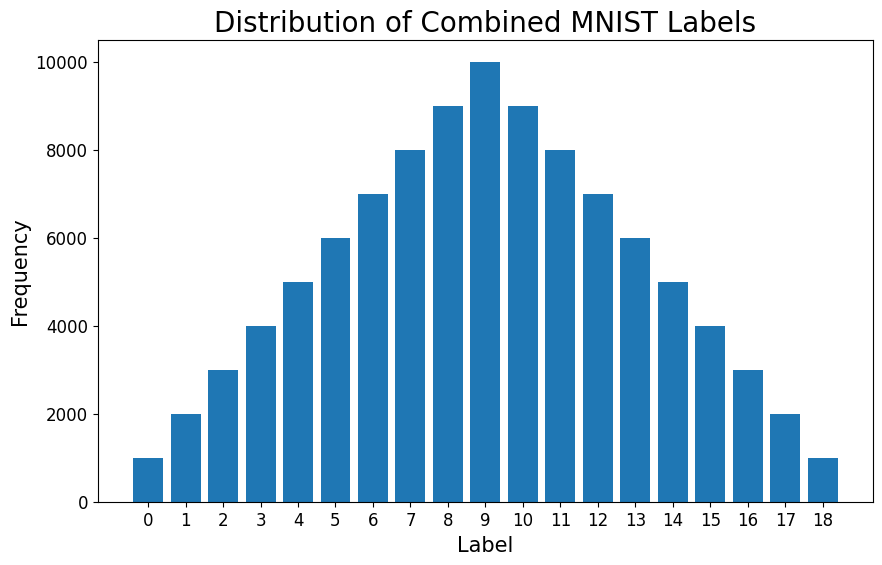

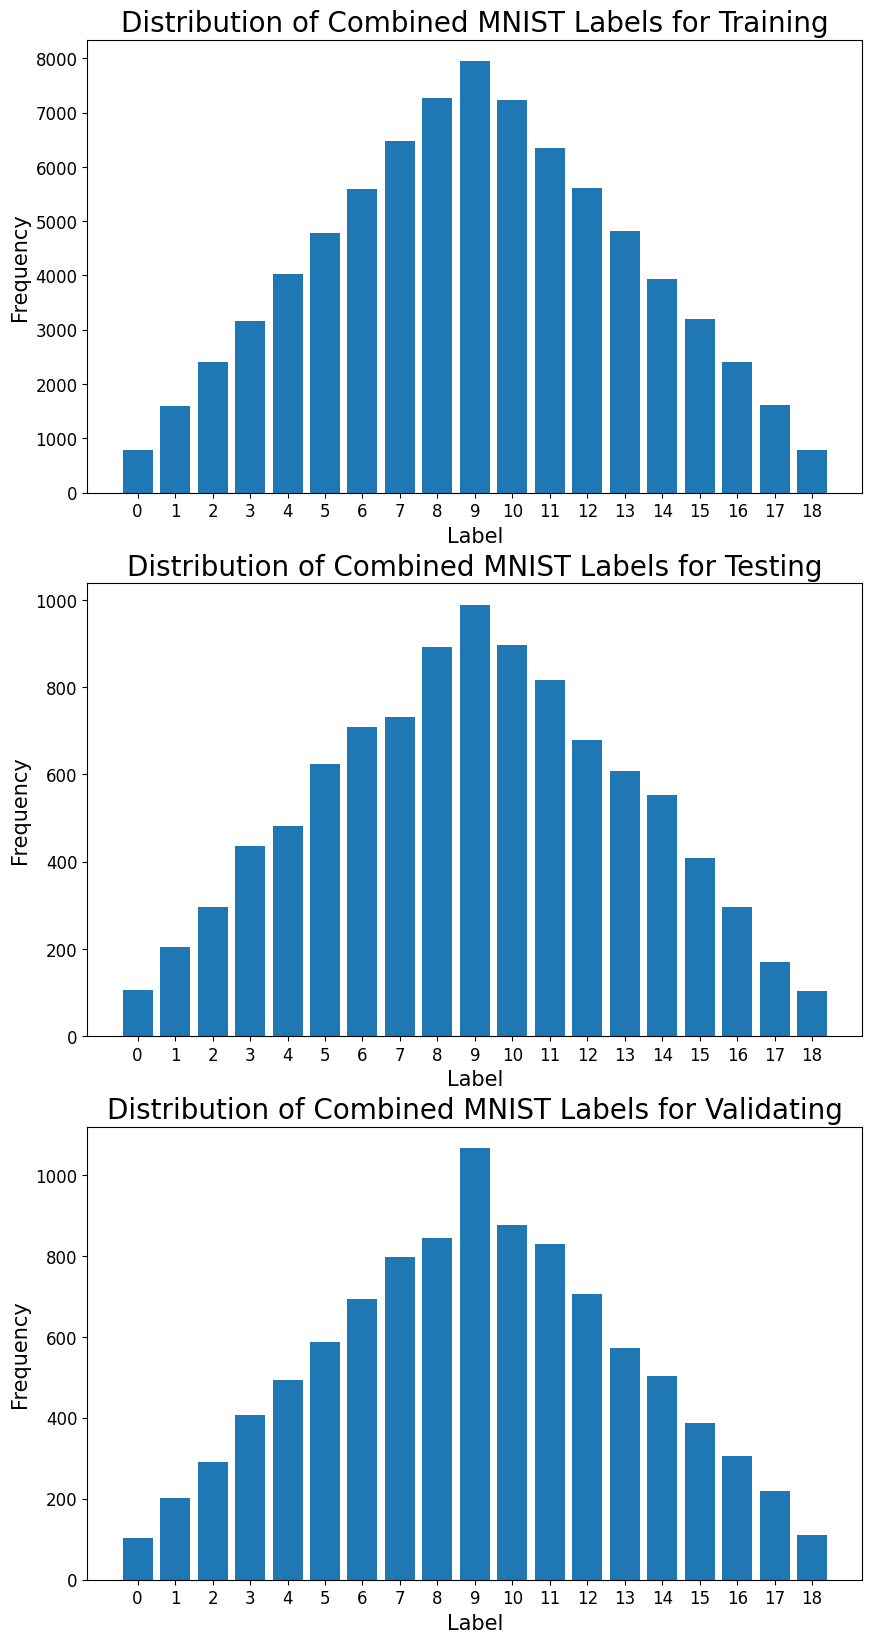

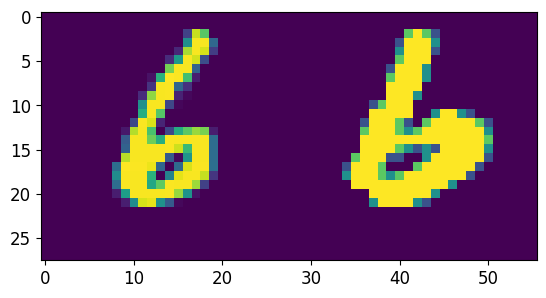

12


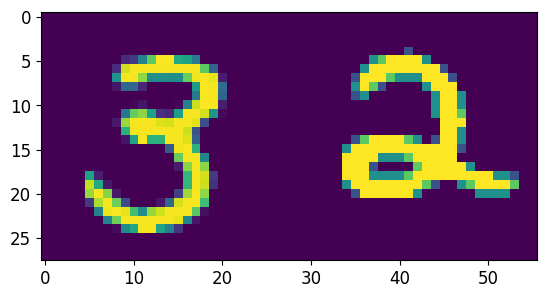

5


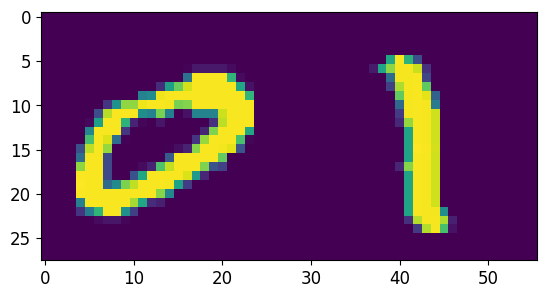

1


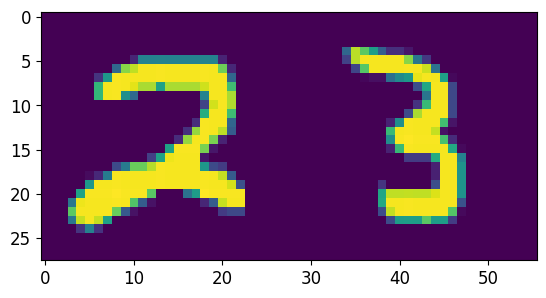

5


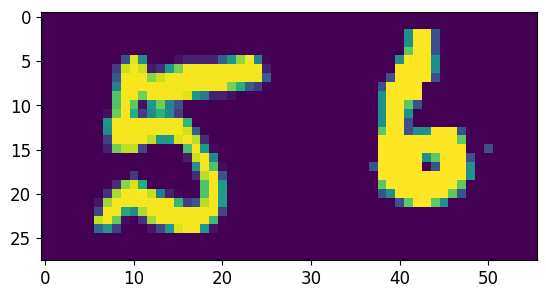

11


In [8]:
def plot_dists():
    X, Y, D1, D2, x_train, y_train, x_test, y_test, x_val, y_val = get_data()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(Y, bins=np.arange(20) - 0.5, rwidth=0.8)
    ax.set_title('Distribution of Combined MNIST Labels', fontsize=20)
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(19))  # Labels from 0 to 18
    fig.savefig('Y_dist.png')
    plt.show()

    label = [y_train, y_test, y_val]
    labels = [np.argmax(y, axis=1) for y in label]
    labels_title = ["training", "testing", "validating"]

    fig, axs = plt.subplots(3, figsize=(10, 20))
    for i in range(len(labels)):
        axs[i].hist(labels[i], bins=np.arange(20) - 0.5, rwidth=0.8)
        axs[i].set_title(f'Distribution of Combined MNIST Labels for {labels_title[i].capitalize()}', fontsize=20)
        axs[i].set_xlabel('Label')
        axs[i].set_ylabel('Frequency')
        axs[i].set_xticks(range(19))

    fig.savefig('Y_split_dist.png')
    plt.show()

    for i in range(5):
        plt.imshow(x_train[i])
        plt.show()
        print(np.where(y_train[i]==1)[0][0])

plot_dists()

In [9]:
X, Y, D1, D2, x_train, y_train, x_test, y_test, x_val, y_val = get_data()

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-4, 1e-3)
    n_layers = trial.suggest_int('n_layers', 4, 6)
    batch_size = trial.suggest_int('batch_size', 16, 256)
    
    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols)))

    neurons = [2**n * 64 for n in range(n_layers)][::-1]

    for i in range(n_layers):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
    model_checkpoint = ModelCheckpoint(f"nn_best_{m_name}.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=0)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=batch_size, verbose=0, callbacks=[model_checkpoint, early_stopping, reduce_lr])
    
    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]

    backend.clear_session()
    del model
    gc.collect()

    return accuracy

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=441))

study.optimize(objective, n_trials=50, show_progress_bar=True)

print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

with open(f"nn_{s_name}.pkl", "wb") as f:
    pickle.dump(study, f)

with open(f'nn_best_{s_name}_params.pkl', 'wb') as f:
    pickle.dump(study.best_trial.params, f)

with open(f"nn_{smp_name}.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

[I 2024-11-30 04:49:42,318] A new study created in memory with name: no-name-56ae503b-437d-45b4-b7be-2c799afe4e29


  0%|          | 0/50 [00:00<?, ?it/s]

2024-11-30 04:49:43.789258: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.
2024-11-30 04:49:44.315234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-11-30 04:49:44.317256: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2918395000 Hz
2024-11-30 04:49:45.339626: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-11-30 04:49:46.980967: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-11-30 04:49:46.982428: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-30 04:49:50.492797: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 62720000 exceeds 10% of free s

[I 2024-11-30 04:51:02,760] Trial 0 finished with value: 0.947700023651123 and parameters: {'learning_rate': 0.0008755439843430998, 'dropout_rate': 0.20418470466361796, 'l2_regularization': 0.00011483918680666603, 'n_layers': 6, 'batch_size': 211}. Best is trial 0 with value: 0.947700023651123.


2024-11-30 04:51:02.819241: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.
2024-11-30 04:51:08.465098: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 62720000 exceeds 10% of free system memory.


[I 2024-11-30 04:52:55,957] Trial 1 finished with value: 0.9431999921798706 and parameters: {'learning_rate': 0.00048215780346319185, 'dropout_rate': 0.16662979401340552, 'l2_regularization': 0.00030417717742514504, 'n_layers': 4, 'batch_size': 113}. Best is trial 0 with value: 0.947700023651123.
[I 2024-11-30 04:54:25,896] Trial 2 finished with value: 0.9510999917984009 and parameters: {'learning_rate': 0.0003161752390068829, 'dropout_rate': 0.2249190259621615, 'l2_regularization': 0.0005479786955786202, 'n_layers': 6, 'batch_size': 190}. Best is trial 2 with value: 0.9510999917984009.
[I 2024-11-30 05:00:42,206] Trial 3 finished with value: 0.942799985408783 and parameters: {'learning_rate': 0.00038393318792467293, 'dropout_rate': 0.061071083562554564, 'l2_regularization': 0.00062373789750464, 'n_layers': 5, 'batch_size': 37}. Best is trial 2 with value: 0.9510999917984009.
[I 2024-11-30 05:02:04,994] Trial 4 finished with value: 0.942799985408783 and parameters: {'learning_rate': 0.

In [15]:
def create_and_save_model():
    with open(f'nn_best_{s_name}_params.pkl', 'rb') as f:
        params = pickle.load(f)

    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols)))

    neurons = [2**n * 64 for n in range(params.get('n_layers'))][::-1]

    for i in range(params.get('n_layers')):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(params.get('l2_regularization'))))
        model.add(Dropout(params.get('dropout_rate')))
        model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50,
                        batch_size=params.get('batch_size'), verbose=1)

    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]
    print(accuracy)
    model.save(f'nn_fitted_{m_name}.keras')
    with open(f'nn_fitted_{h_name}.pkl', "wb") as file:
        pickle.dump(history.history, file)

create_and_save_model()

Epoch 1/50
1633/1633 [==============================] - 22s 13ms/step - loss: 5.2397 - accuracy: 0.2770 - val_loss: 3.8571 - val_accuracy: 0.6628
Epoch 2/50
1633/1633 [==============================] - 19s 12ms/step - loss: 3.7314 - accuracy: 0.6147 - val_loss: 2.8729 - val_accuracy: 0.8279
Epoch 3/50
1633/1633 [==============================] - 19s 12ms/step - loss: 2.8678 - accuracy: 0.7657 - val_loss: 2.2946 - val_accuracy: 0.8791
Epoch 4/50
1633/1633 [==============================] - 18s 11ms/step - loss: 2.2876 - accuracy: 0.8324 - val_loss: 1.8986 - val_accuracy: 0.8969
Epoch 5/50
1633/1633 [==============================] - 19s 12ms/step - loss: 1.8748 - accuracy: 0.8669 - val_loss: 1.5917 - val_accuracy: 0.9128
Epoch 6/50
1633/1633 [==============================] - 19s 12ms/step - loss: 1.5665 - accuracy: 0.8892 - val_loss: 1.3566 - val_accuracy: 0.9215
Epoch 7/50
1633/1633 [==============================] - 18s 11ms/step - loss: 1.3395 - accuracy: 0.9034 - val_loss: 1.1783 -

In [13]:
model = load_model(f'nn_fitted_{m_name}.keras')
sampler = pickle.load(open(f"nn_{smp_name}.pkl", "rb"))
history = pickle.load(open(f"nn_fitted_{h_name}.pkl", "rb"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3213312   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [11]:
x_train, y_train, x_test, y_test, x_val, y_val = load_data()

def nn_predict():
    np.random.seed(220)
    model = load_model(f'nn_fitted_{m_name}.keras')
    predictions = model.predict(x_test)
    idxs = np.random.choice(len(x_test), size=10, replace=False)

    fig, axs = plt.subplots(2, 10, figsize=(20, 10))

    for i in range(10):
        idx = idxs[i]
        axs[0, i].imshow(x_test[idx])
        axs[0, i].set_title(f"True: {np.argmax(y_test, axis=1)[idx]}")
        axs[0, i].axis('off')
        axs[1, i].imshow(x_test[idx])
        axs[1, i].set_title(f"Predicted: {np.argmax(predictions, axis=1)[idx]}")
        axs[0, i].axis('off')

    fig.tight_layout()
    plt.savefig("nn_predictions.png")
    plt.show()

2024-12-08 15:29:34.702412: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-12-08 15:29:34.710206: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2918395000 Hz
2024-12-08 15:29:35.151204: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-12-08 15:29:37.391887: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-12-08 15:29:37.392464: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


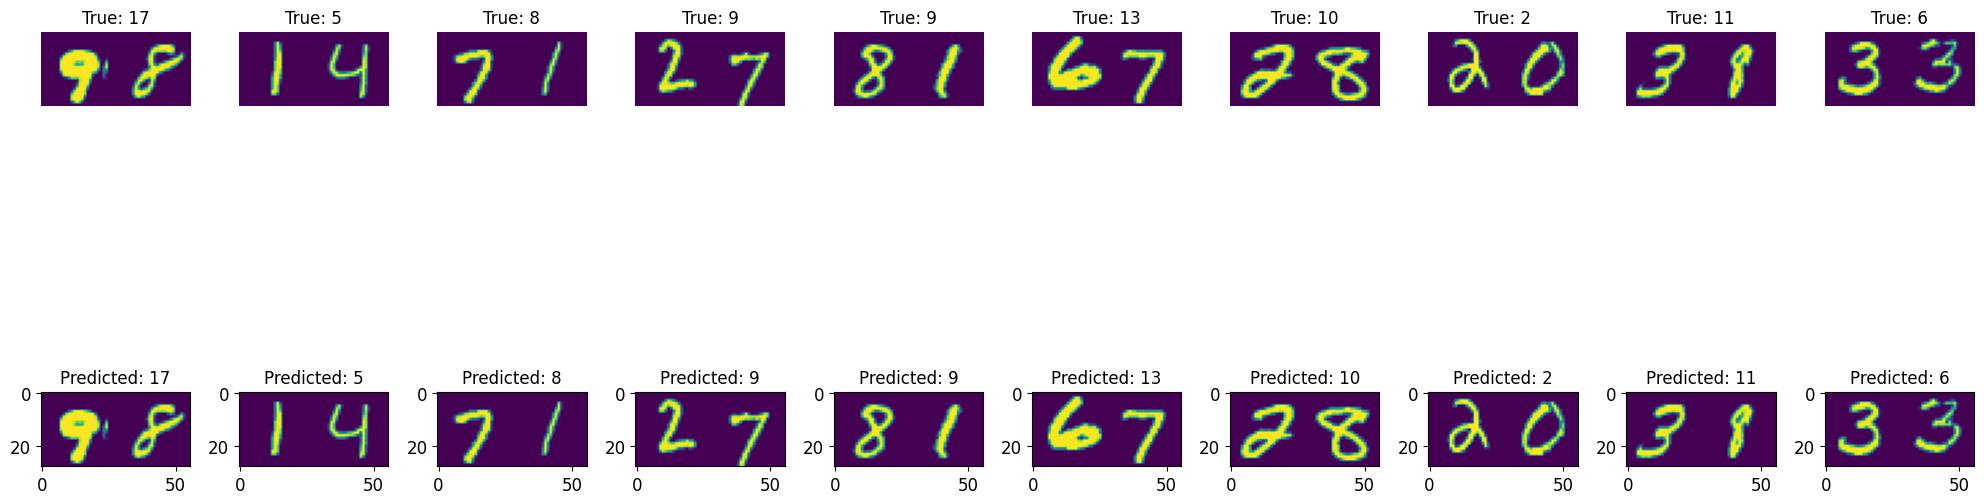

In [12]:
nn_predict()

In [15]:
def get_TSNE():
    x_train, y_train = get_data(output=10000, categorical=False, save=False)[4:6]

    model = load_model(f'nn_fitted_{m_name}.keras')

    with open(f'nn_best_{s_name}_params.pkl', 'rb') as f:
        params = pickle.load(f)
        
    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])
    
    embedding_layer = model.get_layer('dense_5')
    embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
    embeddings = embedding_model.predict(x_train)
    embedding_model.save(f'nn_embedded_{m_name}.keras')
    
    with open(f'nn_embeddings{num}.pkl', "wb") as file:
        pickle.dump(embeddings, file)

    x_train_flat = x_train.reshape(-1, 1568)
    y_train_flat = y_train.astype(int)

    with open(f'nn_embeddings{num}.pkl', "rb") as file:
        embeddings = pickle.load(file)

    perplexities = [5, 30, 50, 100, 200]

    fig, axs = plt.subplots(nrows=len(perplexities), ncols=2, figsize=(15, 35))
    secax = axs[0, 0].secondary_xaxis('top')
    secax2 = axs[0, 1].secondary_xaxis('top')
    
    secax.set_xlabel(f"Perplexity: {perplexities[0]}", fontsize=20)
    secax.set_xticks([])
    secax2.set_xlabel(f"Perplexity: {perplexities[0]}", fontsize=20)
    secax2.set_xticks([])

    for i in range(len(perplexities)):
        tsne = TSNE(n_components=2, perplexity=perplexities[i], random_state=441, max_iter=2000, n_iter_without_progress=400)
        model_embedded = tsne.fit_transform(embeddings[:5000])

        if i==0:
            axs[i, 0].set_title(f"Input dataset", fontsize=20)
            axs[i, 1].set_title(f"Embedding layer", fontsize=20)
        else:
            axs[i, 0].set_title(f"Perplexity: {perplexities[i]}", fontsize=20)
            axs[i, 1].set_title(f"Perplexity: {perplexities[i]}", fontsize=20)


        x_embedded = tsne.fit_transform(x_train_flat[:5000])
        axs[i, 0].scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_train_flat[:5000], cmap='tab20', s=1)
        axs[i, 0].set_xlabel("t-SNE Dim 1")
        axs[i, 0].set_ylabel("t-SNE Dim 2")

        axs[i, 1].scatter(model_embedded[:, 0], model_embedded[:, 1], c=y_train_flat[:5000], cmap='tab20', s=1)
        axs[i, 1].set_xlabel("t-SNE Dim 1")
        axs[i, 1].set_ylabel("t-SNE Dim 2")

        del model_embedded

    fig.tight_layout()
    fig.savefig("tsne.png")
    plt.show()


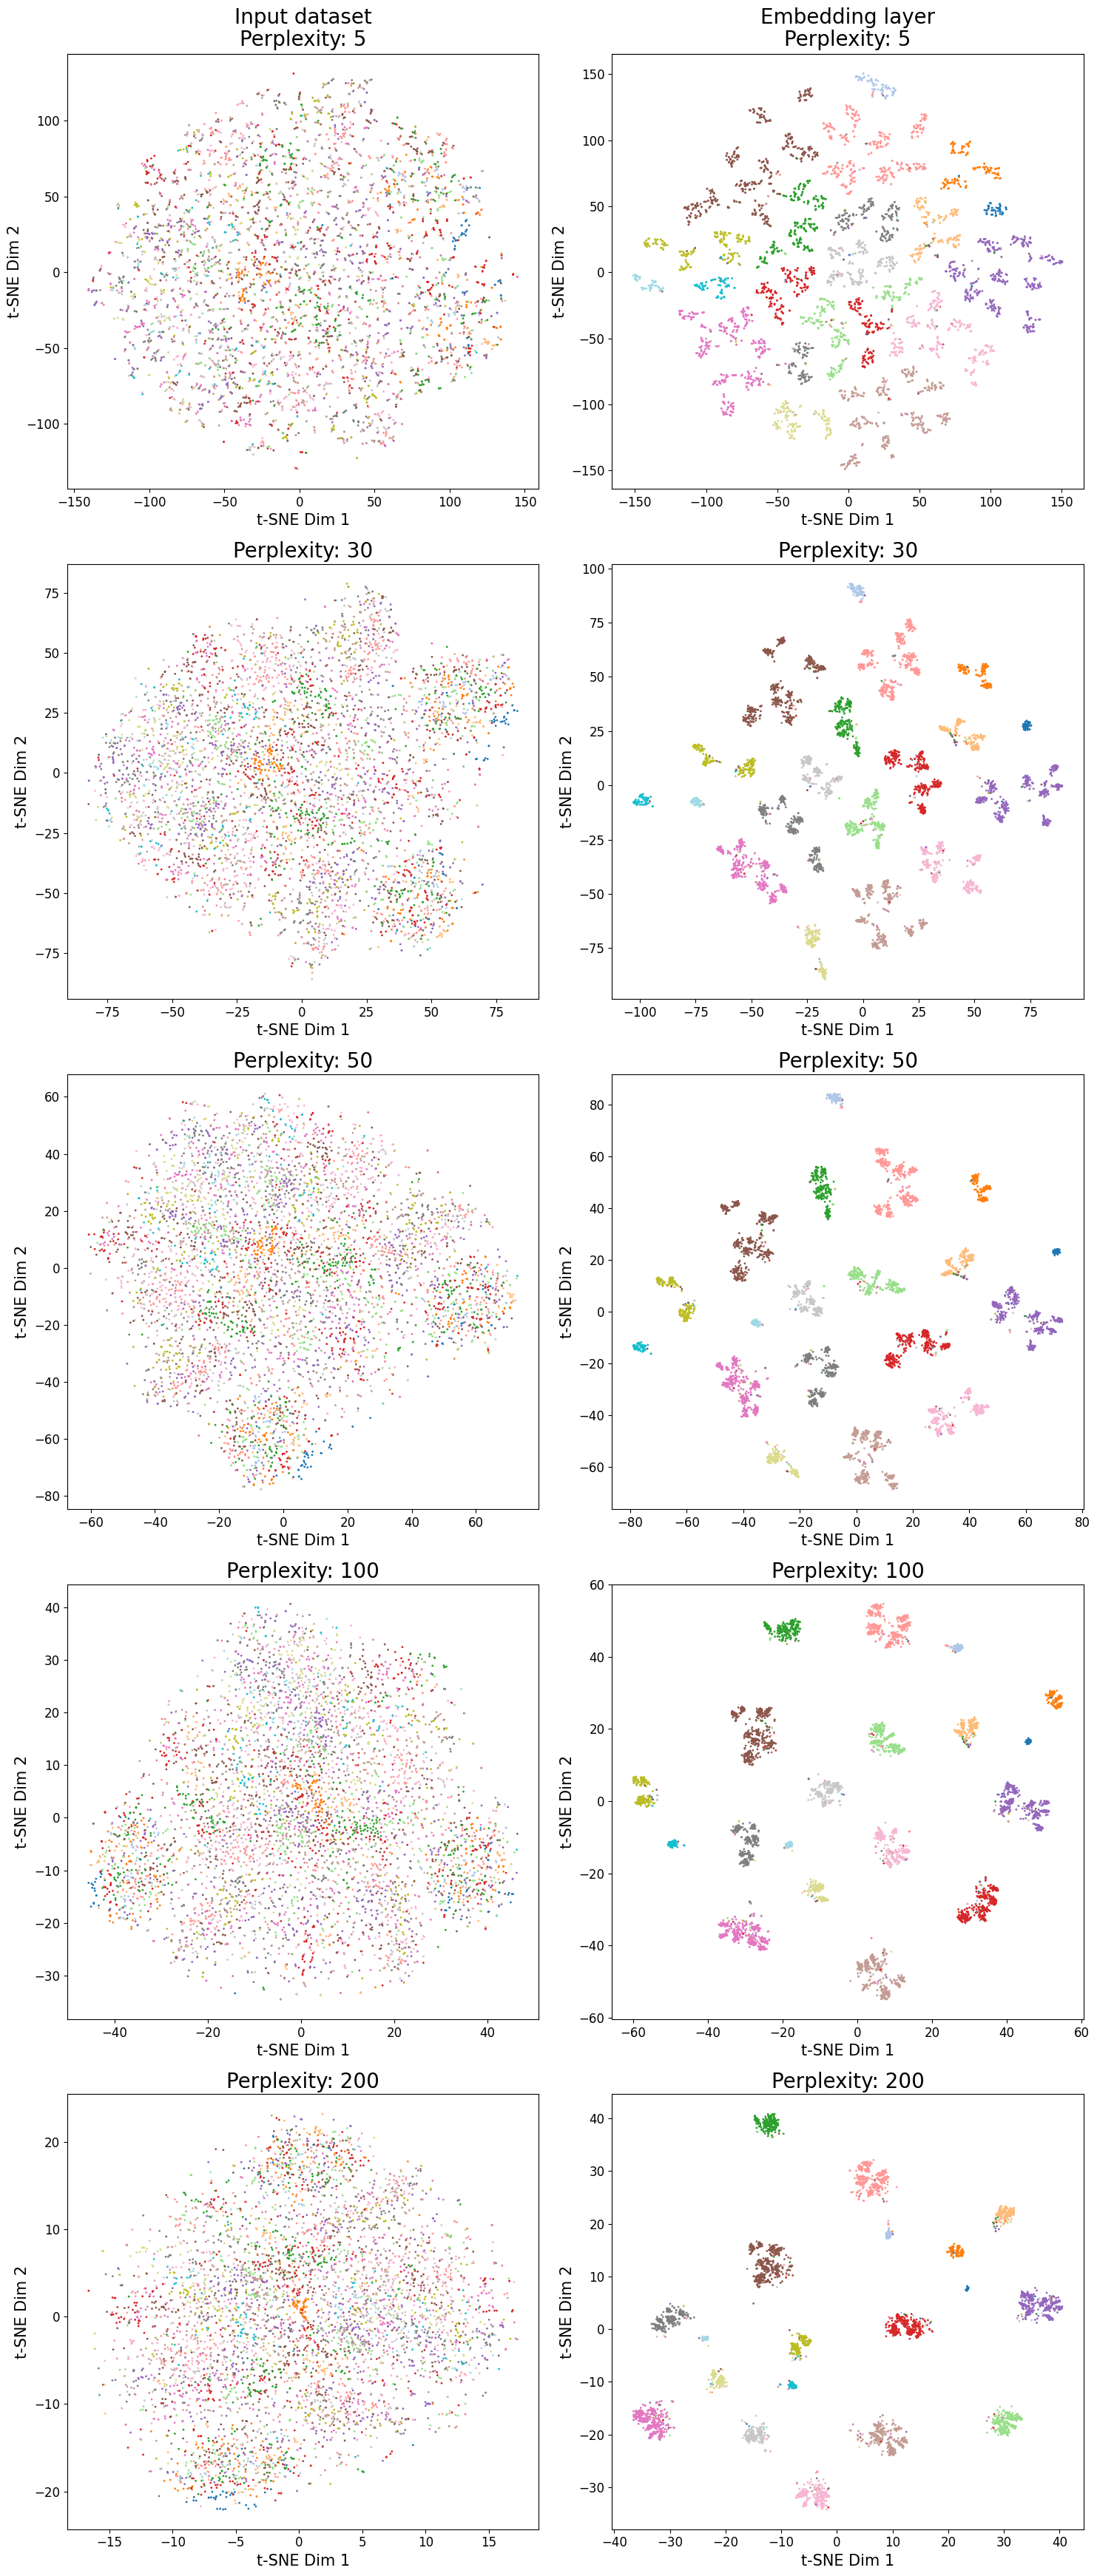

: 

In [16]:
get_TSNE()